In [7]:
import numpy as np
import sklearn.datasets
import sklearn.linear_model
import sklearn.metrics

In [2]:
np.random.seed(42)  # do not change for reproducibility


# Task and problem statement 
In this test we use the [Covertype Data Set](http://archive.ics.uci.edu/ml/datasets/Covertype), a dataset describing cartographic features of areas of land in the USA and also its forest type according to the US Forest Service. There are seven classes (1-7), 581012 samples and 54 features. For this test, we're only interested in cover type 3.

In [4]:
dataset = sklearn.datasets.fetch_covtype()

In [6]:
features = dataset.data
target = dataset.target
#feature_names = dataset.feature_names

In [7]:
# only use a random subset for speed - pretend the rest of the data doesn't exist
random_sample = np.random.choice(len(dataset.data), len(dataset.data) // 10)

In [8]:
len(random_sample)

58101

In [48]:
COVER_TYPE = 3
features = dataset.data[random_sample, :]
target = dataset.target[random_sample] == COVER_TYPE

In [49]:
features.shape

(58101, 54)

A junior colleague tells you that they're getting 96% accuracy using logistic regression. You review their work and see the following:

In [8]:
classifier = sklearn.linear_model.LogisticRegression(solver='liblinear') # do not change this

In [11]:
classifier.fit(features, target)
preds = classifier.predict(features)
acc = sklearn.metrics.accuracy_score(preds, target)

In [12]:
print(f'Accuracy: {acc:.3f}')

Accuracy: 0.961


## Question 1
Comment on what was done above. Evaluate the accuracy more thoroughly. Do not modify the parameters of the model (the cell marked with the comment). Use the classifier object.

## Answer 
In the above, the problem is transformed into a binary classification problem, thereby testing if an observation is either of cover type 3 or not. Then a logistic regression model is trained and evaluated, which achieved an accuracy of approximately 96%. However, the trained model is evaluated on the same data it was trained on, which reminds me of a funny ML meme! ;)  

![title](ml_meme.jpg)

Further, the model was evaluated w.r.t accuracy metric. However, since the classes are imbalanced, using accuracy will give distorted performance view when we'll take a closer look for individual classes. Therefore, we need to interpret using balanced performance metrics such as f1, MCC, or AUC scores. 

So, let's create separate training and test sets: 80:20 ratio. We train the model on training set and evaluate the model on held-out test set to see how accurately we can classify the test samples. 

In [53]:
from sklearn.model_selection import train_test_split

def getDataForCoverType3(dataset, COVER_TYPE, to_sampled=False):  
    random_sample = np.random.choice(len(dataset.data), len(dataset.data) // 10)
    
    if to_sampled: 
        features = dataset.data
        target = dataset.target == COVER_TYPE        

    else:
        features = dataset.data[random_sample, :]
        target = dataset.target[random_sample] == COVER_TYPE
    
    return features, target

In [58]:
COVER_TYPE = 3
features, target = getDataForCoverType3(dataset, COVER_TYPE, False)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

We train the model and generate predictions on unseen test set: 

In [14]:
classifier.fit(X_train, y_train)

I wrote a method, which generates different metrics to evaluate the predictive power of the model on unseen test set. I could include it as a util, but doing here for the time being. 

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

def evaluateModel(model, X_test, y_test, weighted=False):
    '''This method generates different metrics to evaluate the perdictive power of the model on unseen test set'''
    y_pred = model.predict(X_test)
    
    plot_confusion_matrix(model, X_test, y_test)  
    plt.show()
    
    plot_roc_curve(model, X_test, y_test)  
    plt.show()    
        
    plot_precision_recall_curve(model, X_test, y_test)  
    plt.show()
    
    print(classification_report(y_test, y_pred))
    
    if weighted:
        acc = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {acc:.3f}')

        precision = precision_score(y_test, y_pred, average='weighted')
        print(f'Precision: {precision:.3f}')

        recall = recall_score(y_test, y_pred, average='weighted')
        print(f'Recall: {recall:.3f}') 

        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f'F1 score: {f1:.3f}')  

        auc = roc_auc_score(y_test, y_pred, average='weighted') 
        print(f'AUC score: {auc:.3f}')

        mcc = matthews_corrcoef(y_test, y_pred)
        print(f'MCC score: {mcc:.3f}') 
    
    else:     
        print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
        print(f'Precision: {precision_score(y_test, y_pred):.3f}')
        print(f'Recall: {recall_score(y_test, y_pred):.3f}') 
        print(f'F1: {f1_score(y_test, y_pred):.3f}') 
        print(f'AUC score: {roc_auc_score(y_test, y_pred):.3f}')
        print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.3f}') 

Now if we take the weighted average scoring, we will see very different scenario: 

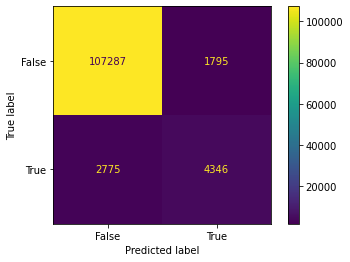

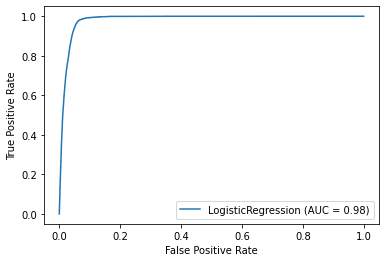

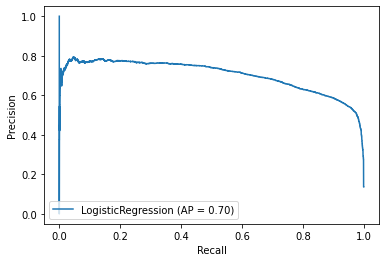

              precision    recall  f1-score   support

       False       0.97      0.98      0.98    109082
        True       0.71      0.61      0.66      7121

    accuracy                           0.96    116203
   macro avg       0.84      0.80      0.82    116203
weighted avg       0.96      0.96      0.96    116203

Accuracy: 0.961
Precision: 0.958
Recall: 0.961
F1 score: 0.959
AUC score: 0.797
MCC score: 0.637


In [39]:
evaluateModel(classifier, X_test, y_test, weighted=True)

Thus having an weighted f1-score of 95.9% on test set is great. However, if we closely observe at the class-wise classification report, we can see that the classifier has made significant misclassification for the true class (cover type 3), making the scores much lower compared than that of false class. This is obvious because classes are severely imbalanced. 

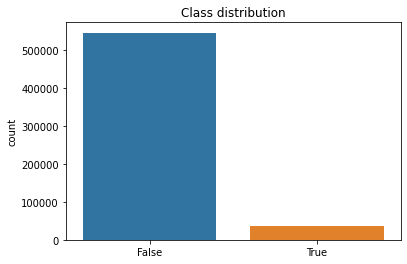

In [40]:
import numpy as np 

unique, counts = np.unique(target, return_counts=True)
dict(zip(unique, counts))

#Plotting class membership
import seaborn as sns
pl = sns.countplot(x=target)
pl.set_title("Class distribution")
plt.show()

Now let's see the same metrics without weighted averageing: 

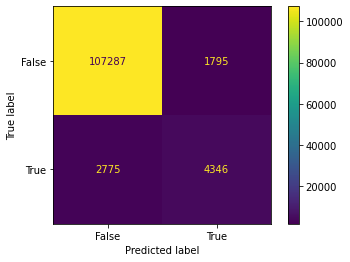

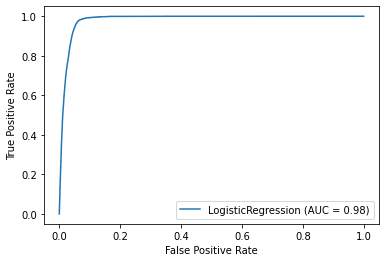

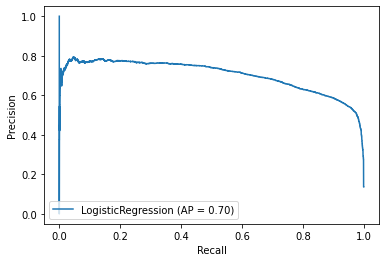

              precision    recall  f1-score   support

       False       0.97      0.98      0.98    109082
        True       0.71      0.61      0.66      7121

    accuracy                           0.96    116203
   macro avg       0.84      0.80      0.82    116203
weighted avg       0.96      0.96      0.96    116203

Accuracy: 0.961
Precision: 0.708
Recall: 0.610
F1: 0.655
AUC score: 0.797
MCC score: 0.637


In [41]:
evaluateModel(classifier, X_test, y_test, weighted=False)

This is obvious because classes are severely imbalanced. 

Now if we take the weighted average scoring, we will see very different scenario: 

## Question 2
Should you get more training data?

## Answer
In my understanding, getting more data in such an imbalanced scenario may not help the classifier. We could go for class balancing, e.g., oversampling or under-sampling. But I'm not gonna do that (that's fairly easy, e.g., using SMOTHE from the imblearn library), as real-life data may not be balanced, e.g., credit card fraud detection, or money laundering use cases, severe imbalance is expected. To prove my hypothesis, let's try training the LR model on full dataset. 

In [60]:
COVER_TYPE = 3
features, target = getDataForCoverType3(dataset, COVER_TYPE, False)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [61]:
import numpy as np 

unique, counts = np.unique(target, return_counts=True)
dict(zip(unique, counts))

{False: 54615, True: 3486}

In [62]:
classifier.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

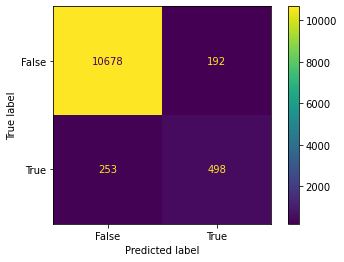

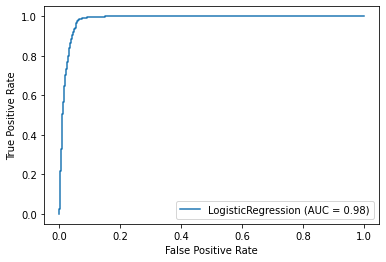

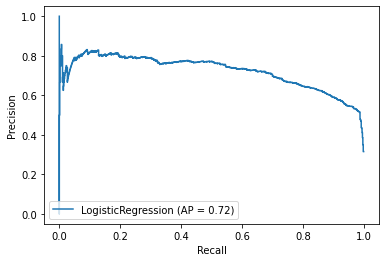

              precision    recall  f1-score   support

       False       0.98      0.98      0.98     10870
        True       0.72      0.66      0.69       751

    accuracy                           0.96     11621
   macro avg       0.85      0.82      0.84     11621
weighted avg       0.96      0.96      0.96     11621

Accuracy: 0.962
Precision: 0.722
Recall: 0.663
F1: 0.691
AUC score: 0.823
MCC score: 0.671


In [63]:
evaluateModel(classifier, X_test, y_test, weighted=False)

Now if we take the weighted average scoring, we will see very different scenario: 

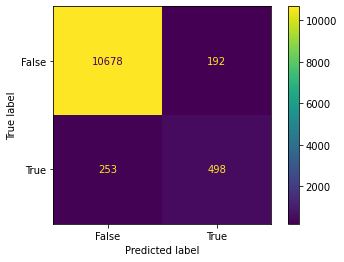

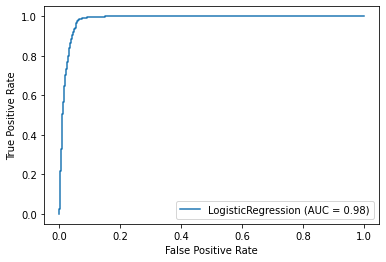

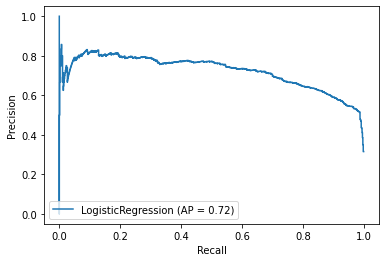

              precision    recall  f1-score   support

       False       0.98      0.98      0.98     10870
        True       0.72      0.66      0.69       751

    accuracy                           0.96     11621
   macro avg       0.85      0.82      0.84     11621
weighted avg       0.96      0.96      0.96     11621

Accuracy: 0.962
Precision: 0.960
Recall: 0.962
F1 score: 0.961
AUC score: 0.823
MCC score: 0.671


In [64]:
evaluateModel(classifier, X_test, y_test, weighted=True)

Overall, even training with all the available data did not help model perform well due to high data imbalance. 

## Question 3
How would you decide which features to include in the deployed model?

In [29]:
### Write your code and explanation here.

## Answer
As not all the features could be of importance or relevant in the predictive modeling, as unimportant features will not only introduce intrinsic noises but also increase the computational complexity of the model. Therefore, it makes sense to identify the most impactful features based on their importance, followed by dropping least important features. 

### Approach 1: w.r.t coefficients 
The very basic thing I'll do is computing and examining the coefficients of the model on standardized parameters, the estimated coefficients, which will be around 1 across features. This then can be used as the feature importance.

In [30]:
# The estimated coefficients will all be around 1:
print(classifier.coef_)

[[-7.78969185e-03  1.36235296e-03  1.07058098e-01  2.29777736e-03
   2.44569635e-03 -1.69712259e-04  7.35979387e-02 -3.25670700e-02
   5.02677637e-02 -2.90889625e-04 -1.21212524e+00 -1.98535686e-02
   9.97517882e-01  2.94581580e-01 -2.54903123e-01  1.44122040e+00
  -2.69568376e-01  1.95503196e+00 -2.02871637e-01  8.89516511e-01
  -6.03769868e-05 -1.12925989e-04 -6.19693092e-02  4.52815625e-01
   1.51686484e-01 -2.51792650e-01 -6.19950246e-01 -2.17254050e-01
  -1.92025868e-03 -7.72826559e-02 -2.10127252e-01 -5.68384667e-02
  -6.07847471e-03 -1.28183575e-01 -1.96222940e-03 -5.86811567e-02
  -1.91704871e-01 -1.43508877e-01 -4.97215095e-04 -5.61565119e-02
  -6.82231104e-03 -9.58283010e-02 -3.63976449e-01 -3.08464106e-01
  -2.57007677e-01 -2.42228023e-01 -6.64819808e-01 -6.35015223e-02
  -4.36096257e-04 -2.86693616e-04 -2.40138573e-05 -5.55105514e-03
  -7.33344089e-03 -2.44659761e-03]]


In [18]:
classifier.fit(X_train / np.std(X_train, 0), y_train)
print((classifier.coef_)*100) 

[[-1.54947372e+02  1.74995761e+01 -1.25349523e+00  4.17641255e+01
   1.13515614e+01 -1.72294093e+01 -9.67104384e+01  8.30804598e+01
  -1.37161869e+02 -3.76210571e+01 -5.69296814e+01 -9.60462612e+00
   3.07460065e+02  1.42936834e+02  5.89271972e+01  1.12306328e+02
   7.56336189e+01  1.44979692e+02  4.06901893e+01  9.80797812e+01
  -2.02722225e-01 -2.83966628e-01 -5.67370926e+00  1.93107259e+02
   1.18013781e+02 -1.33010135e+01  7.79591525e+01  2.18578330e+01
  -1.03334693e+00  5.50628834e+01  5.85776714e+01 -4.90902152e+00
  -6.27388431e+00  4.07123536e+01 -5.05773446e+00 -1.76797358e+01
  -3.33522047e+01 -3.36361709e+01 -1.08908199e+00 -1.46283247e+01
  -8.01688558e+00 -1.42371263e+01 -1.87111829e+01 -1.52104801e+01
  -4.10791988e+01  1.64827303e+02  5.23199799e+01 -1.39337246e+01
  -2.54128698e+00 -2.06841150e+00 -5.70658629e-01 -8.84920202e+00
  -1.12570459e+01 -5.28618147e+00]]


In [19]:
import pandas as pd 

df = pd.DataFrame(zip(dataset.feature_names, np.transpose(classifier.coef_)), columns=['features', 'coef']) 

In [20]:
df.sort_values('coef', ascending=False).head(10)

,features,coef
12,Wilderness_Area_2,[3.074600645295881]
23,Soil_Type_9,[1.9310725930866681]
45,Soil_Type_31,[1.6482730289723515]
17,Soil_Type_3,[1.4497969235959864]
13,Wilderness_Area_3,[1.4293683417940954]
24,Soil_Type_10,[1.1801378141985837]
15,Soil_Type_1,[1.1230632773649667]
19,Soil_Type_5,[0.9807978119024735]
7,Hillshade_Noon,[0.8308045980762364]
26,Soil_Type_12,[0.7795915248171168]


As we can see the Wilderness_Area_2, Soil_Type_9, Soil_Type_31, Soil_Type_3, Wilderness_Area_3 are top-k features. However,  this will work on sklearn 1.1 version only. Therefore, first I extracted feature and target names from the fetch_covtype() method as follows: 

In [ ]:
# dataset = sklearn.datasets.fetch_covtype(return_X_y=False, as_frame=True)
# features = dataset.data
# target = dataset.target
# feature_names = dataset.feature_names
# target_names = dataset.target_names

Then I saved the resultant dataframe in a csv file for reusability. 

In [12]:
# import pandas as pd 

# y = pd.DataFrame(target, columns=target_names)
# data = pd.concat([features, y], ignore_index=False, axis=1).reset_index(drop=True)
# data.to_csv('data.csv', index=False)

### Approach 2: using permutation feature importance
We know that using tree-based models, we can easily extract the permutation feature importance (PFI). However, the recent version of sklearn has introduced the the permutation_importance, which can be extracted via inspection wrapper for any model that provided coefficients or feature importance. 

In [3]:
import pandas as pd 
from sklearn.model_selection import train_test_split, cross_val_score
df = pd.read_csv('data.csv', index_col=None) 
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [4]:
# Create a Pandas dataframe with all the features
X = df.loc[:, df.columns != 'Cover_Type']
y = df['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.inspection import permutation_importance
classifier = sklearn.linear_model.LogisticRegression(solver='liblinear')
classifier.fit(X_train, y_train)

pfi = permutation_importance(classifier, X_test, y_test, n_repeats=5, random_state=42)

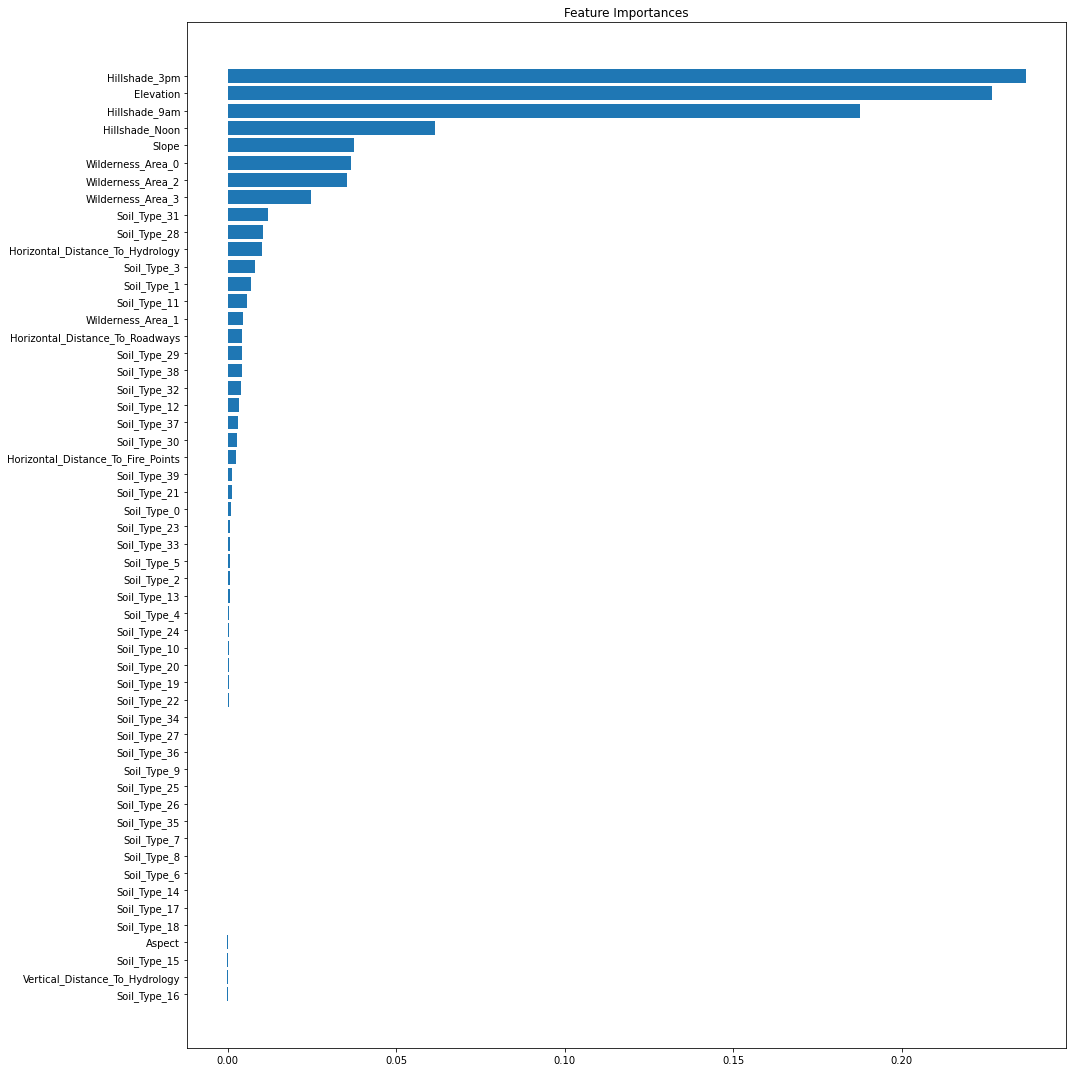

In [27]:
sorted_idx = pfi.importances_mean.argsort()
lr_importances = pd.Series(pfi.importances_mean, index=X_train.columns)

y_ticks = np.arange(0, len(X_train.columns))
fig, ax = plt.subplots(figsize=(15, 15))
ax.barh(y_ticks, lr_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(X_train.columns[sorted_idx])
ax.set_title("Feature Importances")
fig.tight_layout()
plt.show()

This time, Hillshade_3pm, Elevation, Hillshade_9am, Hillshade_Noon, and Slope turn to be are top-k features across different classes. This is very different compared to the first approach.  

In [ ]:
# from sklearn.inspection import DecisionBoundaryDisplay
# disp = DecisionBoundaryDisplay.from_estimator(classifier, X_test, 
#                                               response_method="predict", xlabel="Hillshade_3pm", 
#                                               ylabel="Elevation", alpha=0.5)
# disp.ax_.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor="k")
# plt.show()

### Approach 3: using SHAP 
We already generated PFI using LR model, which provides a view on global feature importance and signifies how important a feature is for the model. However, PFI does not necessarily reflect the intrinsic predictive value of a feature by itself, since a feature that seems to have lower importance for an under/overfitted model could be important for a better-fitted model and the order in which a model observes features can affect the predictions. Therefore, I decided to employ SHAP to provide the explanations of the predictions of the model. SHAP uses Shapley values (SVs) as the measure of feature attribution and are based on coalition game theory. Further, as the order in which features are observed by the model matters, SHAP values explain the output of a function as a sum of the effects of each feature being introduced into a conditional expectation. If a feature has no or almost zero effect on the predicted value, it is expected to produce a SV of 0. If two features contribute equally to the prediction, SVs should be the same.

In [2]:
import shap
# Initialize JavaScript visualization - use Jupyter notebook to see the interactive features of the plots
shap.initjs()

In [31]:
# Create a TreeExplainer and extract shap values from it - will be used for plotting later
explainer = shap.Explainer(classifier, X_train, feature_names=X_train.columns)
shap_values = explainer.shap_values(X_test)

In [52]:
shap_values = explainer(X_test)

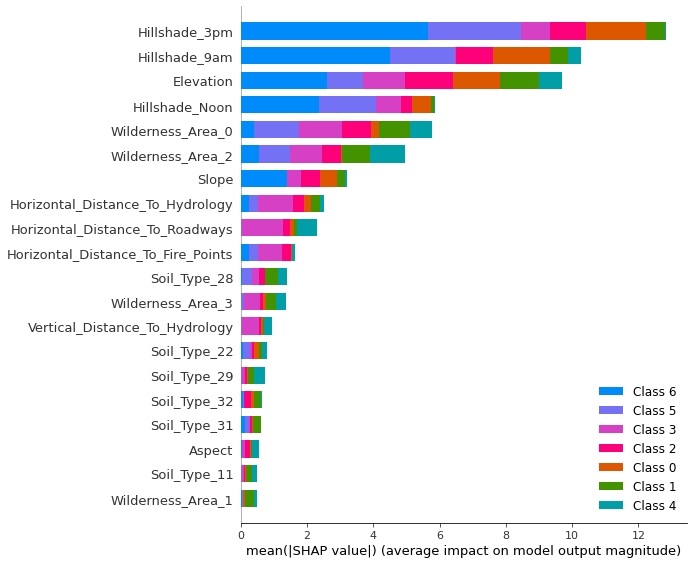

In [32]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

As seen, Hillshade_3pm, Hillshade_9am, Elevation, Hillshade_Noon, and Wilderness_Area_0 turn to be are top-k features across different classes. This is somewhat identical to what we observed using the inspection wrapper. 

### Approach 4: advanced techniques with AutoML 
I used PyCaret - one of my favorite AutoML library. First, I'll compare performance between baseline classifiers and choose a top model whose performance will be evaluated w.r.t different performance metrics. 

In [62]:
from pycaret.classification import *
setup(df, target = 'Cover_Type')

,Description,Value
0,session_id,844
1,Target,Cover_Type
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(581012, 55)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,44
8,Ordinal Features,False
9,High Cardinality Features,False


([<pandas.io.formats.style.Styler at 0x7f10cc712f70>],
         Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
 103058     2724.0    90.0    4.0                             182.0   
 335432     3182.0   285.0   13.0                              42.0   
 128469     2612.0    66.0    8.0                              30.0   
 304327     3033.0    84.0    4.0                               0.0   
 284912     3229.0   333.0   16.0                             108.0   
 ...           ...     ...    ...                               ...   
 273280     2217.0   333.0   29.0                             124.0   
 46317      3234.0   275.0   11.0                             874.0   
 368603     3226.0   315.0    1.0                             525.0   
 242362     2837.0   291.0   33.0                             201.0   
 17454      2665.0   189.0    5.0                             108.0   
 
         Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
 103058        

In [63]:
# This model will be used to compare all the model along with the cross validation
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9635,0.9959,0.9202,0.9635,0.9635,0.9414,0.9414,1.3810
rf,Random Forest Classifier,0.9503,0.9944,0.8974,0.9504,0.9500,0.9198,0.9200,2.4210
et,Extra Trees Classifier,0.9492,0.9938,0.9019,0.9493,0.9489,0.9181,0.9183,2.9000
dt,Decision Tree Classifier,0.9317,0.9450,0.8909,0.9318,0.9318,0.8905,0.8905,0.8010
lightgbm,Light Gradient Boosting Machine,0.8516,0.9523,0.8091,0.8527,0.8515,0.7606,0.7610,2.1520
gbc,Gradient Boosting Classifier,0.7725,0.9065,0.6495,0.7718,0.7687,0.6282,0.6289,73.2880
ridge,Ridge Classifier,0.7007,0.0000,0.3716,0.6797,0.6779,0.5032,0.5055,0.2610
lr,Logistic Regression,0.6840,0.8353,0.3465,0.6503,0.6572,0.4648,0.4680,17.8680
lda,Linear Discriminant Analysis,0.6794,0.8369,0.5763,0.6941,0.6825,0.4963,0.4977,0.8170
svm,SVM - Linear Kernel,0.5326,0.0000,0.3238,0.6019,0.4838,0.2672,0.3134,19.4620


In [71]:
# Build random forest classifier. 
#I picked it eventhough it trankoed 2 due to the fact that we can extract feature importance
rf=create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9493,0.9942,0.8912,0.9493,0.9489,0.9182,0.9183
1,0.9509,0.9945,0.8992,0.9510,0.9506,0.9207,0.9210
2,0.9502,0.9941,0.8978,0.9502,0.9498,0.9196,0.9198
3,0.9492,0.9944,0.8899,0.9493,0.9488,0.9180,0.9182
4,0.9512,0.9947,0.9045,0.9514,0.9510,0.9213,0.9216
5,0.9507,0.9944,0.8973,0.9509,0.9504,0.9205,0.9207
6,0.9502,0.9945,0.8990,0.9503,0.9500,0.9197,0.9199
7,0.9511,0.9947,0.9088,0.9511,0.9508,0.9211,0.9213
8,0.9491,0.9938,0.8828,0.9492,0.9488,0.9179,0.9181


In [72]:
# Whenenver we compare different models or build a model, the model uses deault
#hyperparameter values. Hence, we need to tune our model to get better performance

tuned_rf=tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5197,0.7917,0.7069,0.6875,0.5476,0.3512,0.3782
1,0.5218,0.7910,0.7056,0.6831,0.5497,0.3515,0.3772
2,0.5230,0.7889,0.7110,0.6827,0.5512,0.3526,0.3778
3,0.5188,0.7885,0.7043,0.6816,0.5469,0.3486,0.3745
4,0.5291,0.7894,0.7145,0.6900,0.5575,0.3610,0.3872
5,0.5212,0.7890,0.7062,0.6895,0.5502,0.3530,0.3799
6,0.5177,0.7889,0.7017,0.6850,0.5468,0.3490,0.3758
7,0.5241,0.7876,0.7104,0.6872,0.5519,0.3553,0.3818
8,0.5204,0.7879,0.7081,0.6826,0.5491,0.3510,0.3768


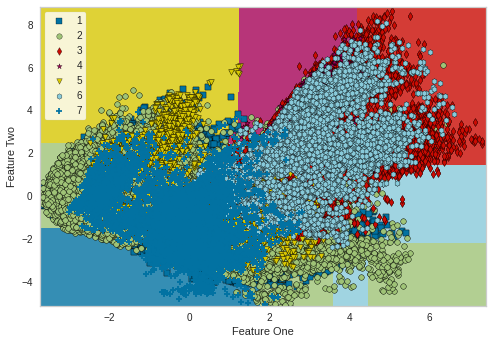

In [73]:
plot_model(tuned_rf, plot='boundary')

It seems the RF model is able to create a clear seperation of samples w.r.t decision boundary. 

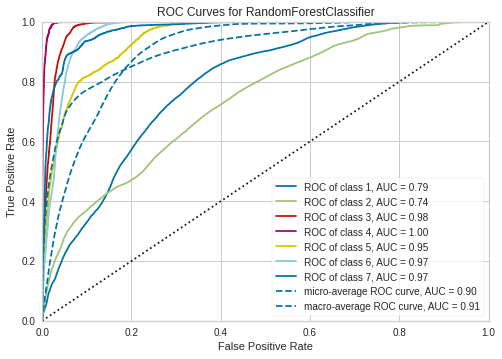

In [74]:
plot_model(tuned_rf, plot='auc', scale = 1)

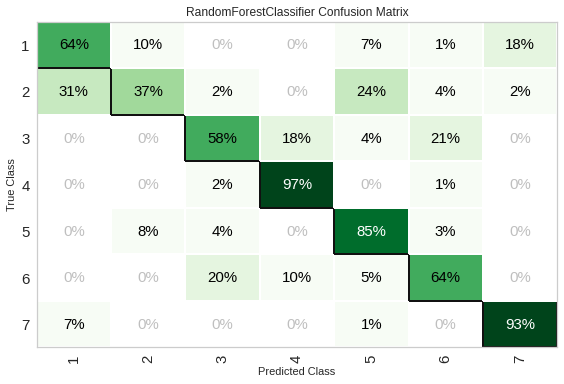

In [75]:
plot_model(tuned_rf, plot='confusion_matrix', plot_kwargs = {'percent' : True})

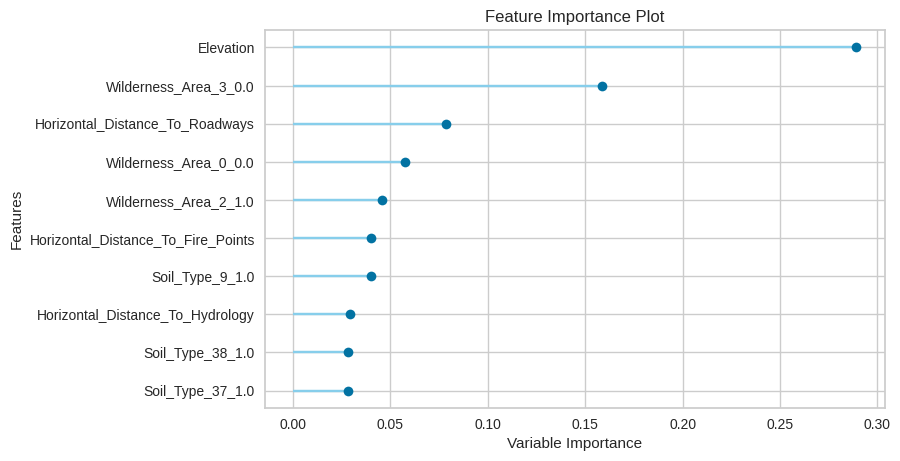

In [76]:
plot_model(tuned_rf, plot='feature')

As seen, Elevation, Wilderness_Area_0, Horizontal_Distance_To_Roadways, Wilderness_Area_0, and Wilderness_Area_2 turn to be are top-k features across different classes. 
This is somewhat identical to what we observed using the inspection wrapper. 

### Approach 5: using SHAP stacking ensemble 

First, we train the StackingClassifier from sklearn, which is technically blending or stacking predictions from logistic regression, decision tree, and extra tree classifiers, where the random forest classifier works as the base estimator.  

In [6]:
import shap
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

# knn = KNeighborsClassifier()
# knn.fit(X_train, y_train)

lr = sklearn.linear_model.LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

et = ExtraTreesClassifier()
et.fit(X_train, y_train)

# svc_linear = sklearn.svm.SVC(kernel='linear', probability=True)
# svc_linear.fit(X_train, y_train)

rf = sklearn.ensemble.RandomForestClassifier()

# stacking_model = sklearn.ensemble.StackingClassifier([('knn', knn), ('svc', svc_linear)], rf)
stacking_model = sklearn.ensemble.StackingClassifier([('lr', lr), ('dt', dt), ('et', et)], rf)

stacking_model.fit(X_train, y_train)

StackingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                               ('dt', DecisionTreeClassifier()),
                               ('et', ExtraTreesClassifier())],
                   final_estimator=RandomForestClassifier())

Then I employ SHAP to provide the explanations of the predictions made by StackingClassifier. RF is an ensemble technique that takes a subset of observations and a subset of variables to build decision trees that creates an ensemble of decision trees. RF first builds decision trees then integrates them to get a more accurate and stable prediction. This is a direct consequence since by maximum voting from a panel of independent juries, we get the final prediction better, fair, and trustworthy than the best jury. 

In [10]:
# Create a TreeExplainer and extract shap values from it - will be used for plotting later
stacking_explainer = shap.KernelExplainer(stacking_model.predict_proba, shap.sample(X_test, 100))

stacking_shap_values = stacking_explainer.shap_values(shap.sample(X_test, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

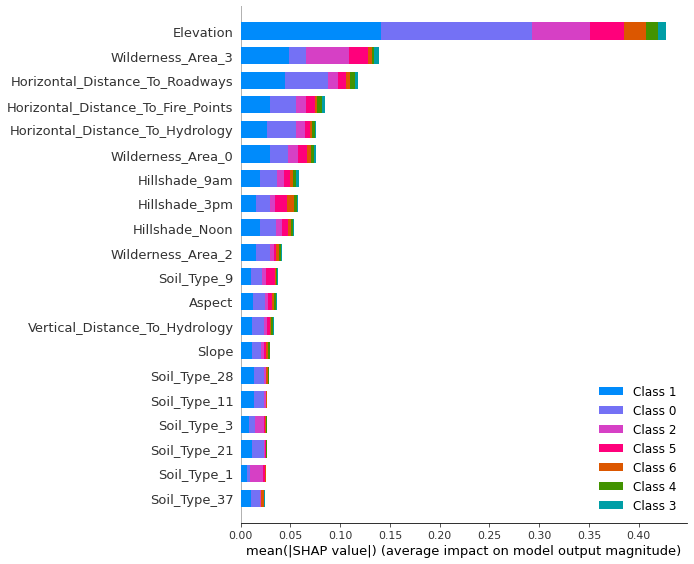

In [11]:
shap.summary_plot(stacking_shap_values, X_test, plot_type="bar")

According to stacking SHAP ensemble, Hillshade_3pm and Hillshade_9am, are no longer top-2 features, but Elevation and Wilderness_Area_3 are across classes. Besides, we can see that features Horizontal_Distance_To_Roadways, Horizontal_Distance_To_Fire_Points, and Horizontal_Distance_to_Hydrology are included in top-5 important feature list. In summary, even if we rely on multiple models, we may end up with slightly different feature importance.

By the way, did we observe how does the stacking classifier performs on the test set? I wrote a method, which generates different metrics to evaluate the predictive power of the model on unseen test set in multi-class classification setting. 

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

def evaluateMulticlass(model, X_test, y_test):
    '''This method generates different metrics to evaluate the perdictive power of the model on unseen test set'''
    y_pred = model.predict(X_test)
    
    plot_confusion_matrix(model, X_test, y_test)  
    plt.show()    
   
    print(classification_report(y_test, y_pred))
    
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {acc:.3f}')

    precision = precision_score(y_test, y_pred, average='micro')
    print(f'Precision: {precision:.3f}')

    recall = recall_score(y_test, y_pred, average='micro')
    print(f'Recall: {recall:.3f}') 

    f1 = f1_score(y_test, y_pred, average='micro')
    print(f'F1 score: {f1:.3f}')  

    mcc = matthews_corrcoef(y_test, y_pred)
    print(f'MCC score: {mcc:.3f}') 

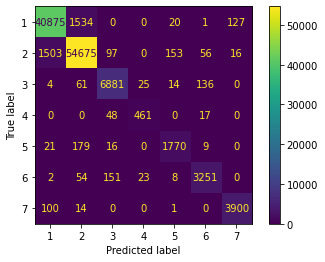

              precision    recall  f1-score   support

           1       0.96      0.96      0.96     42557
           2       0.97      0.97      0.97     56500
           3       0.96      0.97      0.96      7121
           4       0.91      0.88      0.89       526
           5       0.90      0.89      0.89      1995
           6       0.94      0.93      0.93      3489
           7       0.96      0.97      0.97      4015

    accuracy                           0.96    116203
   macro avg       0.94      0.94      0.94    116203
weighted avg       0.96      0.96      0.96    116203

Accuracy: 0.962
Precision: 0.962
Recall: 0.962
F1 score: 0.962
MCC score: 0.939


In [25]:
evaluateMulticlass(stacking_model, X_test, y_test)

### Feature selection

We can also use ELI5's feature selection method (well, of course, I could go for other approaches such as RFE), as it may be useful for introspection too. That is, once we compute feature importances, we can drop unimportant features. 

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel

import numpy as np
from eli5.permutation_importance import get_score_importances

perm = PermutationImportance(classifier, cv=5)
perm.fit(X_train, y_train)

Now that the PFI attribute is available, we can use it for feature selection. Besides, in order to avoid wanted feature, let's e.g. select only those features for which the accuracy is increase by at least 0.05: 

In [ ]:
sel = SelectFromModel(perm, threshold=0.05, prefit=True)
X_trans = sel.transform(X_train)

### Note on feature selection by dropping less important ones  
Research has suggested to use permutation feature importance (as well as other feature importance measures) very carefully. The reasoning is that, if several features are correlated, and the estimator uses them all equally, their corresponding permutation importance can be low for all of these features: dropping one of the features may not affect the result, as estimator still has an access to the same information from other features. Therefore, if features are dropped based on importance threshold, such correlated features could be dropped all at the same time, regardless their usefulness. 